In [1]:
import datetime
import json
import os
import random
import sys
import warnings
import pandas as pd

sys.path.append(os.path.join(os.getcwd(), '../../../common'))
from ppg_feature_processor import generate_train_feature

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*Conversion of an array with ndim > 0 to a scalar is deprecated.*")

In [2]:
# 读取 Excel 文件'
middleSchool_userProfile_file_new = r'C:\Users\Administrator\Desktop\Backend-Algorithm\Algorithm\PPG\ppg_depression\data_preprocess\new_data_2024_09_20\outdir\MiddleSchool_Depression_Anxiety.xlsx'


In [3]:
insomnia_positive_threshold = 13
insomnia_negative_threshold = 1

In [4]:
### READ THE MIDDLESCHOOL SUBJECTS
df_middle = pd.read_excel(middleSchool_userProfile_file_new, sheet_name= 'Insomnia')

middle_pos_subjects = df_middle[df_middle['insomnia_result'] >= insomnia_positive_threshold]['subjectid'].values.tolist()
middle_neg_subjects = df_middle[df_middle['insomnia_result'] <= insomnia_negative_threshold]['subjectid'].values.tolist()

print(f"middle insomnia positive subjects count: {len(middle_pos_subjects)}")
print(f"middle insomnia negative subjects count: {len(middle_neg_subjects)}")

middle insomnia positive subjects count: 13
middle insomnia negative subjects count: 47


In [5]:
old_insomnia_positive_threshold = 16
old_insomnia_negative_threshold = 9
middleSchool_userProfile_file_old = r'C:\Users\Administrator\Desktop\Backend-Algorithm\Algorithm\PPG\ppg_insomnia\data_preprocess\middle_school_data_insomia.xlsx'

In [6]:
### READ THE MIDDLESCHOOL SUBJECTS
df_middle_old = pd.read_excel(middleSchool_userProfile_file_old)
df_middle_old = df_middle_old[(df_middle_old['Total'] > old_insomnia_positive_threshold) | (df_middle_old['Total'] < old_insomnia_negative_threshold)]
print(f"Midlle schold available subject count: {df_middle_old.shape}")


middle_pos_subjects_old = df_middle_old[df_middle_old['Total'] > old_insomnia_positive_threshold]['userId'].values.tolist()
middle_neg_subjects_old = df_middle_old[df_middle_old['Total'] < old_insomnia_negative_threshold]['userId'].values.tolist()

print(f"middle stress positive subjects count: {len(middle_pos_subjects_old)}")
print(f"middle stress negative subjects count: {len(middle_neg_subjects_old)}")

Midlle schold available subject count: (273, 13)
middle stress positive subjects count: 133
middle stress negative subjects count: 140


In [7]:
profile_dict = dict()

for _, row in df_middle.iterrows():
    userId = row['subjectid']
    gender = row['gender']
    age = row['age']
    profile_dict[userId] = (gender, age)

for _, row in df_middle_old.iterrows():
    userId = row['userId']
    gender = row['gender']
    age = row['age']
    profile_dict[userId] = (gender, age)



In [8]:
random.shuffle(middle_pos_subjects)
random.shuffle(middle_neg_subjects)

test_subject_count = 8

test_pos_subjects = middle_pos_subjects[0:test_subject_count]
test_neg_subjects =  middle_neg_subjects[0:test_subject_count]

train_pos_subjects =    middle_pos_subjects[test_subject_count::] #+ middle_pos_subjects_old 
train_neg_subjects = middle_neg_subjects[test_subject_count::] #+ middle_neg_subjects_old

print(f"train postive subjects: {len(train_pos_subjects)}")
print(f"train negative subjects: {len(train_neg_subjects)}")

print(f"test postive subjects: {len(test_pos_subjects)}")
print(f"test negative subjects: {len(test_neg_subjects)}")


train postive subjects: 5
train negative subjects: 39
test postive subjects: 8
test negative subjects: 8


In [9]:
def load_wave_middleSchool(path):
    try:
        with open(path, 'r', encoding='utf-8') as file:  
            data = json.load(file)
        return data["ppg_raw_data"]
    except:
        print("Subject Not Loaded")
        pass


def load_wave_middleSchool_old(path):
    try:
        with open(path, 'r', encoding='utf-8') as file:  
            data = json.load(file)
            list_data = data['RawResults'][0]['rawDatas']
            final = [i/100000 for i in list_data]
        return final
    except (KeyError, IndexError, TypeError):
        with open(path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data["datas"]

In [10]:
sample_freq = 125
sample_window_minute = 1.0

middle_file_dir = r'C:\Users\Administrator\Desktop\middle_school_data\ppg_data'
old_middle_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data'

In [11]:
def generate_dataset(subject_collection, label, data_aug_times=1):
    ignored_id = []
    dataset = pd.DataFrame()
    for subject in subject_collection:
            subject_wave = []

            if subject in (middle_pos_subjects + middle_neg_subjects):
                files = os.listdir(middle_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(middle_file_dir, file)
                        print(f"middle file path: {file_path}")
                        tmp_wave = load_wave_middleSchool(file_path)
                        subject_wave += tmp_wave
            elif subject in (middle_neg_subjects_old + middle_pos_subjects_old):
                files = os.listdir(old_middle_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(old_middle_file_dir, file)
                        print(f"middle file path: {file_path}")
                        tmp_wave = load_wave_middleSchool_old(file_path)
                        subject_wave += tmp_wave
            
            if len(subject_wave) < (sample_freq * (sample_window_minute) * 60):
                print(f"Small time for subj: {subject} is: {len(subject_wave)/(sample_freq*60)}")
                ignored_id.append({'id': id, 'Time Length of data in minute ': f"{len(subject_wave)/(125 * 60):.02f}"})
                continue
            else:
                print(f"Recording time for subj: {subject} is: {len(subject_wave)/(sample_freq*60)}")
                subject_dataset = generate_train_feature(subject, subject_wave, label, profile_dict[subject][0], profile_dict[subject][1], sample_freq, sample_window_minute, data_aug_times, if_gender = True)
                dataset = pd.concat([dataset, subject_dataset], ignore_index=True)
    return dataset


In [12]:
train_neg_dataset = generate_dataset(train_neg_subjects, label=0, data_aug_times=1)
train_pos_dataset = generate_dataset(train_pos_subjects, label=1, data_aug_times=6)

middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\064be51e-f7c6-e196-7c30-57fe14950331.json
Recording time for subj: 064be51e-f7c6-e196-7c30-57fe14950331 is: 15.016666666666667
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\a3bb10b9-2ac2-ecf1-a40d-4cec92f0a2c9.json
Recording time for subj: a3bb10b9-2ac2-ecf1-a40d-4cec92f0a2c9 is: 15.033333333333333
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\1eb091d2-2d29-6b79-4681-3dc9b04218fc.json
Recording time for subj: 1eb091d2-2d29-6b79-4681-3dc9b04218fc is: 15.2
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\ad674d01-4c98-9197-6876-ae14db61152f.json
Recording time for subj: ad674d01-4c98-9197-6876-ae14db61152f is: 15.05
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\bb2eaaba-1b05-bf28-3bd6-7c76fa5fd943.json
Recording time for subj: bb2eaaba-1b05-bf28-3bd6-7c76fa5fd943 is: 15.033333333333333
middle 

In [13]:
test_pos_dataset = generate_dataset(test_pos_subjects, label=1, data_aug_times=1)
test_neg_dataset = generate_dataset(test_neg_subjects, label=0, data_aug_times=1)

middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\59d9f43d-b1cb-5c9e-82b2-e6f649c67f20.json
Recording time for subj: 59d9f43d-b1cb-5c9e-82b2-e6f649c67f20 is: 15.033333333333333
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\bf102cd1-feed-4807-9ce7-d8bbfe9d0afd.json
Recording time for subj: bf102cd1-feed-4807-9ce7-d8bbfe9d0afd is: 15.05
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\dc7e8552-e3c4-4695-379c-10e144338a4b.json
Recording time for subj: dc7e8552-e3c4-4695-379c-10e144338a4b is: 15.1
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\5eae2457-6636-54b5-7789-0bfcf4f0db53.json
Small time for subj: 5eae2457-6636-54b5-7789-0bfcf4f0db53 is: 0.6
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\2a4bd1c8-888b-915b-d645-1ae939a492c5.json
Recording time for subj: 2a4bd1c8-888b-915b-d645-1ae939a492c5 is: 15.0
middle file path: C:\Users\Administrator

In [14]:
def selecting_specific_time(dataset, time = 5):
    final_dataset = pd.DataFrame()
    subject_names =  (dataset['id'].unique()).tolist()
    for sub_name in subject_names:
        sub_data = dataset[dataset['id'] ==  sub_name].sample(time, ignore_index = True)
        final_dataset = pd.concat([final_dataset, sub_data], ignore_index = True)
    return final_dataset

In [15]:
# test_neg_dataset = selecting_specific_time(test_neg_dataset)
# test_pos_dataset = selecting_specific_time(test_pos_dataset)

In [16]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (424, 40)
train neg sample shape: (555, 40)
test pos sample shape: (105, 40)
test neg sample shape: (105, 40)


In [17]:
columns_drop = []
for col in train_pos_dataset.columns[:-4]:
    nan_count = (train_pos_dataset[col] == 0).sum() 
    if nan_count > (len(train_pos_dataset) // 4): 
        columns_drop.append(col)

train_pos_dataset_final = train_pos_dataset.drop(columns=columns_drop, inplace=False)
train_neg_dataset_final = train_neg_dataset.drop(columns=columns_drop, inplace=False)

test_pos_dataset_final = test_pos_dataset.drop(columns=columns_drop, inplace=False)
test_neg_dataset_final = test_neg_dataset.drop(columns=columns_drop, inplace=False)

In [18]:
print(f"After remove the invalid columns, train pos shape: {train_pos_dataset_final.shape}")
print(f"After remove the invalid columns, train neg shape: {train_neg_dataset_final.shape}")

print(f"After remove the invalid columns, test pos shape: {test_pos_dataset_final.shape}")
print(f"After remove the invalid columns, test neg shape: {test_neg_dataset_final.shape}")

After remove the invalid columns, train pos shape: (424, 32)
After remove the invalid columns, train neg shape: (555, 32)
After remove the invalid columns, test pos shape: (105, 32)
After remove the invalid columns, test neg shape: (105, 32)


#### Do The Normalization for the Train Dataset and Test Dataset

In [19]:
profile_columns = ['wave_quality', 'age', 'gender', 'label', 'id']

In [20]:
# 合并训练集
train_combined = pd.concat([train_pos_dataset_final, train_neg_dataset_final])

# 需要归一化的列
columns_to_normalize = train_combined.columns.difference(profile_columns)

# 计算最大值和最小值
min_values = train_combined[columns_to_normalize].min()
max_values = train_combined[columns_to_normalize].max()

# 保存最大值和最小值到CSV
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
outdir = os.path.join(os.getcwd(), 'outdir')
os.makedirs(outdir, exist_ok=True)
min_max_df = pd.DataFrame({'min': min_values, 'max': max_values})
min_max_df.to_csv(f'{outdir}/ppg_isnomnia_norm_minmax_values_{current_date}.csv', index=True)


# 定义min-max归一化函数
def normalize(df, min_values, max_values):
    return (df - min_values) / (max_values - min_values)

# 对训练集进行归一化
train_pos_dataset_final[columns_to_normalize] = normalize(train_pos_dataset_final[columns_to_normalize], min_values, max_values)
train_neg_dataset_final[columns_to_normalize] = normalize(train_neg_dataset_final[columns_to_normalize], min_values, max_values)

# 从CSV文件中读取最小值和最大值
min_max_df = pd.read_csv(f'{outdir}/ppg_isnomnia_norm_minmax_values_{current_date}.csv', index_col=0)
min_values = min_max_df['min']
max_values = min_max_df['max']

# 对测试集进行归一化
test_pos_dataset_final[columns_to_normalize] = normalize(test_pos_dataset_final[columns_to_normalize], min_values, max_values)
test_neg_dataset_final[columns_to_normalize] = normalize(test_neg_dataset_final[columns_to_normalize], min_values, max_values)


#### Save As Pkl File

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

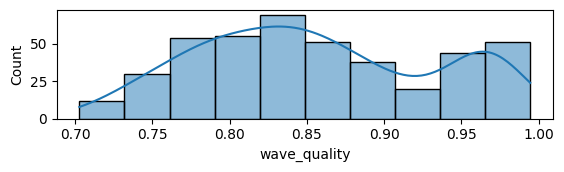

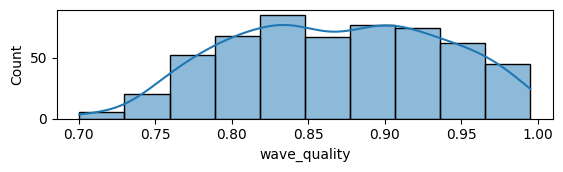

<Axes: xlabel='wave_quality', ylabel='Count'>

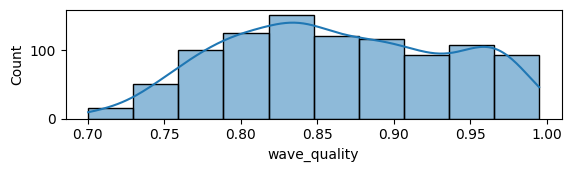

In [22]:
from matplotlib import figure

plt.subplot(3, 1, 1)  # 1行2列，第1个子图
sns.histplot(train_pos_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 2)  # 1行2列，第1个子图
sns.histplot(train_neg_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 3)  # 1行2列，第1个子图
sns.histplot(train_combined['wave_quality'], kde=True, bins=10)

In [23]:
wave_quality_threshold = 0.90

In [24]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (424, 40)
train neg sample shape: (555, 40)
test pos sample shape: (105, 40)
test neg sample shape: (105, 40)


In [25]:
train_pos_dataset_final_filter = train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold]
train_neg_dataset_final_filter = train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold]

print(f"After quality filter, train positive sample count: {train_pos_dataset_final_filter.shape[0]}")
print(f"After quality filter, train negative sample count: {train_neg_dataset_final_filter.shape[0]}")


After quality filter, train positive sample count: 121
After quality filter, train negative sample count: 203


In [26]:
sample_folder = os.path.join(os.getcwd(), 'samples')
os.makedirs(sample_folder, exist_ok=True)


# 定义要保存的文件路径
train_pos_path = os.path.join(sample_folder, 'train_pos_dataset.pkl')
train_neg_path = os.path.join(sample_folder, 'train_neg_dataset.pkl')
test_pos_path = os.path.join(sample_folder, 'test_pos_dataset.pkl')
test_neg_path = os.path.join(sample_folder, 'test_neg_dataset.pkl')

# 保存 DataFrame 为 .pkl 文件
train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_pos_path)
train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_neg_path)
test_pos_dataset_final.to_pickle(test_pos_path)
test_neg_dataset_final.to_pickle(test_neg_path)

In [27]:
print(train_pos_dataset_final.columns)

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20',
       'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_LF', 'HRV_HF',
       'HRV_VHF', 'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF',
       'wave_quality', 'label', 'id', 'age', 'gender'],
      dtype='object')
